https://nbviewer.org/github/qzed/irl-maxent/blob/master/notebooks/maxent.ipynb so good

Max entropy IRL
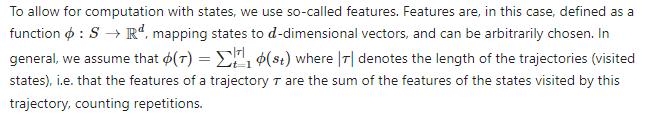

- main idea is feature expectation matching
- in expectation the features describing the states of our world should be in expectation visited equally often by the agent following our recovered reward function and by the expert.

think about this
- But isn't it good if we know more? The less entropy the better, right? you may ask. No. Not for many optimization problems, or in general, when working with incomplete information: Consider a problem, like feature-expectation matching, which has multiple solutions fullfilling our constraints. The only information which we give our solver for this problem is the feature-expectations we want to replicate. All solutions provided by our solver contain this information. Yet they most certainly have a different entropy values. This must mean that (at least) some solutions have additional information that we did not provide, i.e. they have a bias. By choosing the solution with maximum entropy, we choose the solution with minimal information. Note that all solutions already satisfy our constraints, thus we actually choose the solution that fits our information with a minimal bias.

assumption
- assumption of Maximum Entropy IRL is that we know the behavior of our MDP, i.e. we have a perfect model representing the transition probabilities p(st+1∣st,at)
, so the only thing we actually need to learn is the reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys, os
sys.path.append(os.path.abspath(os.path.join('utils/')))


In [2]:
import gridworld as W                       # basic grid-world MDPs
import solver as S 
import trajectory as T    
import plot as P   
import optimizer as O                 # solvers for MDPs

In [3]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [4]:
def setup_mdp():
    world = W.IcyGridWorld(size = 5, p_slip = 0.2)

    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65
    terminal = [24]

    return world, reward, terminal

world, reward, terminal = setup_mdp()

In [5]:
world.n_states, world.n_actions

(25, 4)

In [6]:
world.p_transition.shape

(25, 25, 4)

In [7]:
world.state_index_transition(4, 0)

4

In [8]:
# w = lambda x: x**50
# value = [2.25026084, 2.68159603, 3.22012176, 3.86459025, 3.93203287, 2.61121456,
#          3.14929297, 3.83584087, 4.67978015, 4.72899741, 2.78885031, 3.33070124,
#          4.00842094, 4.82096435, 5.73518417, 3.2958783, 3.95611537, 4.78824052,
#          5.79526101, 7.01120237, 3.87260789, 4.68943532, 5.73165257, 7.01103596,
#          8.57997999]
# np.array([
#         np.array([w(value[world.state_index_transition(s, a)]) for a in range(world.n_actions)])
#         for s in range(world.n_states)
#     ])

In [9]:
def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200
    discount = 0.9
    weighting = lambda x: x**50
    start = [0]
    # print(world.p_transition, reward, terminal, discount)
    value = S.value_iteration(world.p_transition, reward, discount)
    # print(value)
    policy = S.stochastic_policy_from_value(world,value, w=weighting)
    policy_exce = T.stochastic_policy_adapter(policy)
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exce, start, terminal))
    
    return tjs, policy

trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)


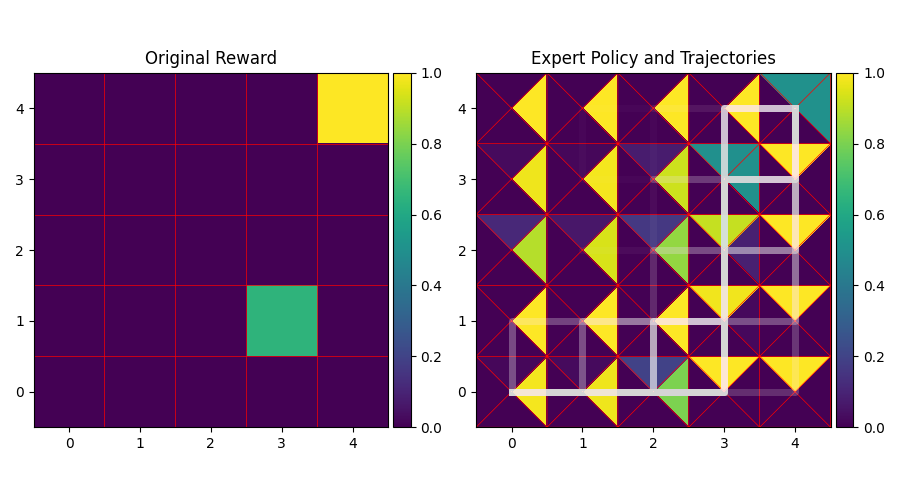

In [10]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_stochastic_policy(ax, world, expert_policy, **style)
fig.colorbar(p, cax=cax)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

fig.tight_layout()
plt.show()


In [23]:
def feature_extraction_from_trajectories(features, trajectories):
    n_states, n_features = features.shape
    fe = np.zeros(n_features)
    for t in trajectories:
        for s in t.states():
            fe+=features[s,:]

    return fe/len(trajectories)

In [12]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories) 

In [34]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)

    #backward pass
    # initialize at terminal states
    zs = np.zeros(n_states)
    zs[terminal] = 1.0

    # perform backward pass
    for _ in range(2*n_states):
        za = np.zeros((n_states, n_actions))

        for s_from, a in product(range(n_states), range(n_actions)):
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from])*zs[s_to]

        zs = za.sum(axis=1)

    p_action = za/zs[:, None]

    #forward pass
    d = np.zeros((n_states, 2*n_states))
    d[:,0] = p_initial
    for t in range(1, 2*n_states):
        for s_to in range(n_states):
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    return d.sum(axis=1)

In [38]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps = 1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    e_features = feature_extraction_from_trajectories(features, trajectories)

    p_intial = initial_probabilities_from_trajectories(n_states, trajectories)

    omega = init(n_features)
    delta = np.inf

    optim.reset(omega)
    count = 0
    while delta > eps:
        omega_old = omega.copy()
        reward = features.dot(omega)
        # print(reward)
        e_svf = compute_expected_svf(p_transition, p_intial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        optim.step(grad)

        delta = np.max(np.abs(omega - omega_old))
        count += 1
        if count % 20 == 0:
            print(f'Iteration {count}, delta {delta}')

    return features.dot(omega)

In [39]:
features  = W.state_features(world)
init = O.Constant(1.0)

optim = O.ExpSga(lr = O.linear_decay(lr0 = 0.2))

reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)


Iteration 20, delta 0.0039307705544290306
Iteration 40, delta 0.0016776907369766558
Iteration 60, delta 0.001027736793214662
Iteration 80, delta 0.0007280122548179446
Iteration 100, delta 0.0005579914713481071
Iteration 120, delta 0.0004493949023631205
Iteration 140, delta 0.0003763115541375317
Iteration 160, delta 0.00032281935048827926
Iteration 180, delta 0.00028204607047943586
Iteration 200, delta 0.00024999921658752644
Iteration 220, delta 0.00022418784872013653
Iteration 240, delta 0.0002029800762273215
Iteration 260, delta 0.00018526363383897237
Iteration 280, delta 0.00017025518435487275
Iteration 300, delta 0.0001573876300181576
Iteration 320, delta 0.00014624064949309012
Iteration 340, delta 0.00013649631665135775
Iteration 360, delta 0.00012790985634891783
Iteration 380, delta 0.00012028985053191832
Iteration 400, delta 0.00011348452149384514
Iteration 420, delta 0.00010738491065831468
Iteration 440, delta 0.00010189060523768667


In [40]:
reward, reward_maxent

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.65, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 1.  ]),
 array([0.15598952, 0.40611116, 0.64551689, 0.65501044, 0.42097964,
        0.22379158, 0.27320489, 0.39401492, 0.8635641 , 0.37686478,
        0.35599877, 0.33712819, 0.30920492, 0.74253803, 0.37758136,
        0.47214796, 0.42479313, 0.35521149, 0.64920933, 0.57741689,
        0.5400314 , 0.47988444, 0.38878229, 0.52803741, 1.19041385]))

In [41]:
reward_maxent

array([0.15598952, 0.40611116, 0.64551689, 0.65501044, 0.42097964,
       0.22379158, 0.27320489, 0.39401492, 0.8635641 , 0.37686478,
       0.35599877, 0.33712819, 0.30920492, 0.74253803, 0.37758136,
       0.47214796, 0.42479313, 0.35521149, 0.64920933, 0.57741689,
       0.5400314 , 0.47988444, 0.38878229, 0.52803741, 1.19041385])

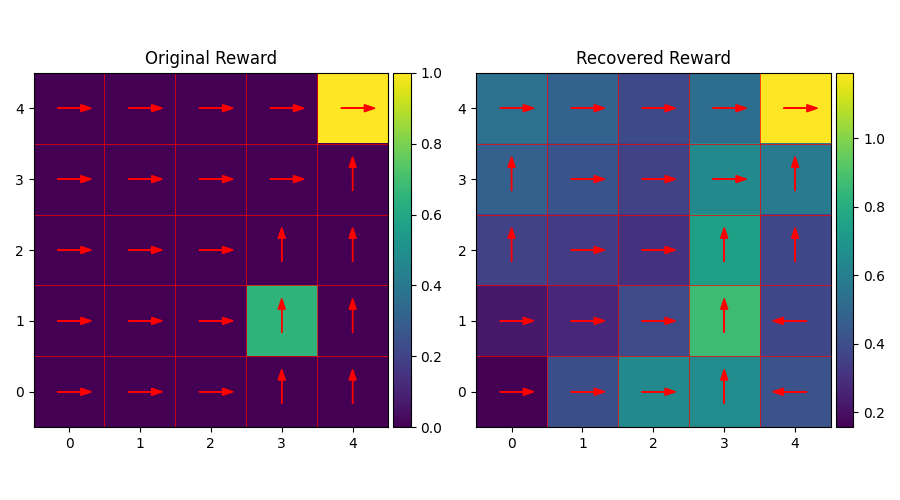

In [42]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.8), color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()

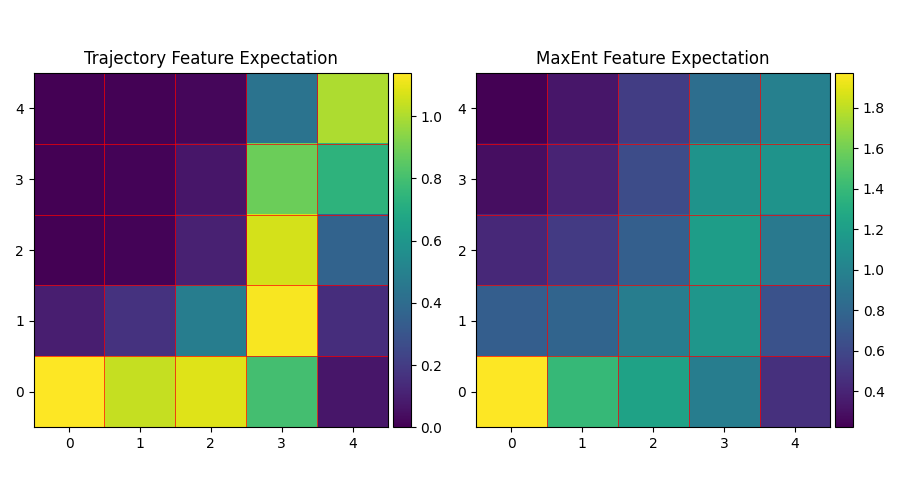

In [43]:
# Note: this code will only work with one feature per state
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_extraction_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, e_features, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, features.T.dot(e_svf), **style)
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()